In [1]:
import cv2
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

## Image augmentation

In [2]:
class ImageAugmentation:
    def __init__(self, path = "./"):
        self.path = path
        self.image_dims = (255, 255)
        self.folder_list = os.listdir(path)       
        
    def resize(self):
        for folder in self.folder_list:
            self.files = os.listdir(self.path + '/' + folder)
            for file in self.files:
                    img = cv2.imread(self.path + "/" + folder + "/" + file)
                    resized_img = cv2.resize(img, self.image_dims,interpolation=cv2.INTER_AREA)                
                    cv2.imwrite(self.path + "/" + folder + "/" + file, resized_img)
                    
    def rotateY(self):
        for folder in self.folder_list:
            self.files = os.listdir(self.path + '/' + folder)
            
            for file in self.files:
                constraint = ["rx_", "ry_"]
                if file[:3] not in constraint and self.path.split('/')[-1] != 'test':
                    img = cv2.imread(self.path + "/" + folder + "/" + file)
                    rows, cols, dim = img.shape
                    My = np.float32([[-1,  0, cols],
                                     [0 ,  1, 0   ],
                                     [0 ,  0, 1   ]])
                    
                    reflected_img = cv2.warpPerspective(img,My,(int(cols),int(rows)))
                    cv2.imwrite(self.path + "/" + folder + "/" + "ry_"+ file,reflected_img)


In [5]:
#trainDataAugmentation = ImageAugmentation("./data/train")
#trainDataAugmentation.resize()
#trainDataAugmentation.rotateY()

#testDataAugmentation = ImageAugmentation("./data/test")
#testDataAugmentation.resize()

## Costum dataloader

In [4]:
class CDataset(Dataset):
    def __init__(self, train = False, test = False):
        if(train):
            self.data_path = "./data/train"
        if(test):
            self.data_path = "./data/test"
            
        self.data = []
        self.folder_list = os.listdir(self.data_path)
        self.class_map = {"abraham_grampa_simpson": 0, "bart_simpson": 1, 
                          "homer_simpson": 2, "lisa_simpson": 3, 
                          "marge_simpson": 4,  "principal_skinner": 5}        

        for folder in self.folder_list:
            for file in os.listdir(self.data_path + '/' + folder):
                self.data.append([file, folder])
                
        
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, i):
        file, folder = self.data[i]
        img = cv2.imread(self.data_path + '/' + folder + '/' + file)
        class_id = self.class_map[folder]
        img_tensor = torch.tensor(img, dtype=torch.float)
        img_tensor = img_tensor.permute(2,0,1)
        class_id = torch.tensor([class_id])
        return img_tensor, class_id

In [5]:
batch_size = 5
train_dataset = CDataset(train=True)
data_loader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = CDataset(test=True)
data_loader_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

16380


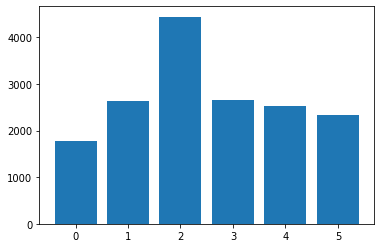

In [6]:
chart = {"abraham_grampa_simpson": 0, "bart_simpson": 0, 
                          "homer_simpson": 0, "lisa_simpson": 0, 
                          "marge_simpson": 0,  "principal_skinner": 0} 

br = 0
for name, folder in train_dataset.data:
    for key in chart:
        if folder == key:
            chart[key] += 1
    br += 1
print(br)
names = [train_dataset.class_map[k] for k in chart.keys()]
values = list(chart.values())
plt.bar(names, values)
plt.show()

## CNN



In [7]:
if torch.cuda.is_available():
    device = torch.device("cuda:0") 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [8]:
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()

        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=128, kernel_size=7, padding=2, stride=2),
            nn.BatchNorm2d(128),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5, padding=2, stride=2),
            nn.BatchNorm2d(256),
            nn.PReLU(),  
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(384),
            nn.PReLU(),  
            
            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(384),
            nn.PReLU(),  
            
            nn.AvgPool2d(kernel_size=15, stride=1),
        )


        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.6),
            nn.Linear(384, 6),
            nn.PReLU(),
        )


    def forward(self, x): 
        x = self.conv_layer(x)
        x = torch.flatten(x, 1)
        x = self.fc_layer(x)
        return x

In [9]:
net = CNN()
def calc_input_dims():
        batch_data = torch.zeros((1, 3, 255, 255))
        
        batch_data = net.conv_layer(batch_data)
        
        return int(np.prod(batch_data.size()))
calc_input_dims()

384

In [10]:
lossF = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

In [11]:
#net.to(device)  
epochs = 50
train_loss = []
test_loss = []

for epoch in range(epochs): 
    print("Starting epoch #" + str(epoch))
    running_loss_train = 0.0
    running_loss_test = 0.0
    net.to(torch.device("cuda:0")) 
    for i, data in enumerate(data_loader_train, 0):
        # inputs, labels = data
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = lossF(outputs, labels.flatten())
        loss.backward()
        optimizer.step()

        running_loss_train += loss.item()
    
    net.to(torch.device("cpu")) 
    with torch.no_grad():
        for data in data_loader_test:
            images, labels = data
            outputs = net(images)

            loss = lossF(outputs, labels.flatten())
            running_loss_test += loss.item()
    
    train_loss.append(float(running_loss_train))
    test_loss.append(float(running_loss_test)) 

print('Finished Training')

Starting epoch #0
Starting epoch #1
Starting epoch #2
Starting epoch #3
Starting epoch #4
Starting epoch #5
Starting epoch #6
Starting epoch #7
Starting epoch #8
Starting epoch #9
Starting epoch #10
Starting epoch #11
Starting epoch #12
Starting epoch #13
Starting epoch #14
Starting epoch #15
Starting epoch #16
Starting epoch #17
Starting epoch #18
Starting epoch #19
Starting epoch #20
Starting epoch #21
Starting epoch #22
Starting epoch #23
Starting epoch #24
Starting epoch #25
Starting epoch #26
Starting epoch #27
Starting epoch #28
Starting epoch #29
Starting epoch #30
Starting epoch #31
Starting epoch #32
Starting epoch #33
Starting epoch #34
Starting epoch #35
Starting epoch #36
Starting epoch #37
Starting epoch #38
Starting epoch #39
Starting epoch #40
Starting epoch #41
Starting epoch #42
Starting epoch #43
Starting epoch #44
Starting epoch #45
Starting epoch #46
Starting epoch #47
Starting epoch #48
Starting epoch #49
Finished Training


In [12]:
PATH = "./SimpsonsCNN"
torch.save(net.state_dict(), PATH)

## Evaluation

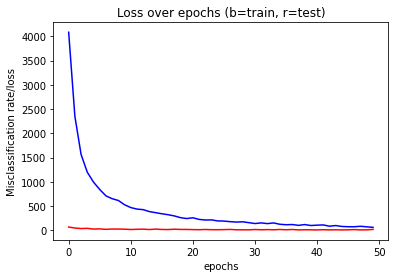

In [13]:
x = np.arange(epochs)
y_train = np.array(train_loss) 
y_test = np.array(test_loss)
plt.title('Loss over epochs (b=train, r=test)')
plt.xlabel('epochs')
plt.ylabel('Misclassification rate/loss')
plt.plot(x, y_train, c='b')
plt.plot(x, y_test, c='r')
plt.show()

In [18]:
net.to(torch.device("cpu")) 

correct = 0
total = 0
predict = []
true = []
            
with torch.no_grad():
    for data in data_loader_test:
        images, labels = data
        outputs = net(images)

        for i in range(batch_size):
            try:
                true.append(int(labels[i]))
                predict.append(np.array(outputs[i]).argmax())
                if np.array(outputs[i]).argmax() == labels[i]:
                    correct += 1
                total+=1
            except:
                pass

    print(correct, total)

print('Accuracy on test images: %d %%' % (
    round(100 * correct / total)))

284 300
Accuracy on test images: 95 %


In [19]:
conf_matrix = confusion_matrix(true, predict)

class Confusion_matrix_extraction():
    def __init__(self):
        self.M = []
        self.class_map = {"abraham_grampa_simpson": 0, "bart_simpson": 1, 
                          "homer_simpson": 2, "lisa_simpson": 3, 
                          "marge_simpson": 4,  "principal_skinner": 5} 
        self.num_of_classes = len(self.class_map)

    def extract_all(self, CM):
        for k in range(self.num_of_classes):
            tp, fn, fp, tn = 0, 0, 0, 0
            for i in range(self.num_of_classes):
                for j in range(self.num_of_classes):
                    if i == j and i == k:
                        tp = CM[i][j]
                    elif i == k and (j > i or j < i):
                        fn += CM[i][j]
                    elif j == k and (i > j or i < j):
                        fp += CM[i][j]
                    else:
                        tn += CM[i][j]
            self.M.append([tn, fp, fn, tp])  
            
            
        for i in range(self.num_of_classes):
            position = list(self.class_map.values()).index(i)
            print("Class: ", list(self.class_map.keys())[position])
            print("[tn, fp, fn, tp]: ", self.M[i])
            print("Accuracy: ", self.accuracy(i))
            print("Misclassification: ", self.misclassification(i))
            print("Precision: ", self.precision(i))
            print("Recall: ", self.recall(i))
            print("*********************************************")
    
    def tn_fp_fn_tp(self, _class):
        return self.M[_class]
    
    def accuracy(self, _class):
        tn, fp, fn, tp = self.M[_class]
        return (tp+tn)/(tp+tn+fp+fn) * 100
    
    def misclassification(self, _class):
        tn, fp, fn, tp = self.M[_class]
        return (fp+fn)/(tp+tn+fp+fn) * 100
    
    def precision(self, _class):
        tn, fp, fn, tp = self.M[_class]
        return tp/(tp+fp) * 100
    
    def recall(self, _class):
        tn, fp, fn, tp = self.M[_class]
        return tp/(tp+fn) * 100

In [20]:
CME = Confusion_matrix_extraction()
CME.extract_all(conf_matrix)

Class:  abraham_grampa_simpson
[tn, fp, fn, tp]:  [249, 1, 6, 44]
Accuracy:  97.66666666666667
Misclassification:  2.3333333333333335
Precision:  97.77777777777777
Recall:  88.0
*********************************************
Class:  bart_simpson
[tn, fp, fn, tp]:  [247, 3, 1, 49]
Accuracy:  98.66666666666667
Misclassification:  1.3333333333333335
Precision:  94.23076923076923
Recall:  98.0
*********************************************
Class:  homer_simpson
[tn, fp, fn, tp]:  [248, 2, 0, 50]
Accuracy:  99.33333333333333
Misclassification:  0.6666666666666667
Precision:  96.15384615384616
Recall:  100.0
*********************************************
Class:  lisa_simpson
[tn, fp, fn, tp]:  [247, 3, 5, 45]
Accuracy:  97.33333333333334
Misclassification:  2.666666666666667
Precision:  93.75
Recall:  90.0
*********************************************
Class:  marge_simpson
[tn, fp, fn, tp]:  [245, 5, 0, 50]
Accuracy:  98.33333333333333
Misclassification:  1.6666666666666667
Precision:  90.90909